# 🤖 Baseline Model - UK Housing Price Prediction

**Team :** Error 400

**Purpose:** Build a quick baseline model to:
- Establish initial performance benchmark
- Test the modeling pipeline
- Identify which features are most important

**Model:** We'll use a simple Random Forest model as our baseline.

**Dataset:** 500K clean housing records (1995-2017)

In [1]:
# ==========================================
# 1. Import Libraries
# ==========================================
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries loaded successfully")

✅ Libraries loaded successfully


## 📂 Load Clean Data

We'll load the cleaned data we prepared in the previous notebook.

In [2]:
# ==========================================
# 2. Load Clean Data
# ==========================================
print("📂 Loading clean housing data...")
data_path = Path("data/cleaned/housing_clean.parquet")
df = pd.read_parquet(data_path)

print(f"✅ Loaded {len(df):,} records")
print(f"Columns: {df.columns.tolist()}")
print(f"\nData shape: {df.shape}")
print(f"Date range: {df['year'].min()} - {df['year'].max()}")
print(f"Price range: £{df['price'].min():,} - £{df['price'].max():,}")

# Show first rows
df.head()

📂 Loading clean housing data...
✅ Loaded 496,823 records
Columns: ['price', 'transfer_date', 'property_type', 'is_new', 'tenure_type', 'town_city', 'district', 'county', 'year', 'month', 'quarter', 'day_of_week', 'property_type_label', 'is_new_build', 'tenure_label']

Data shape: (496823, 15)
Date range: 1995 - 1995
Price range: £10,000 - £1,000,000


,price,transfer_date,property_type,is_new,tenure_type,town_city,district,county,year,month,quarter,day_of_week,property_type_label,is_new_build,tenure_label
0,25000,1995-08-18,T,N,F,OLDHAM,OLDHAM,GREATER MANCHESTER,1995,8,3,4,Terraced,False,Freehold
1,42500,1995-08-09,S,N,F,GRAYS,THURROCK,THURROCK,1995,8,3,2,Semi-Detached,False,Freehold
2,45000,1995-06-30,T,N,F,HIGHBRIDGE,SEDGEMOOR,SOMERSET,1995,6,2,4,Terraced,False,Freehold
3,43150,1995-11-24,T,N,F,BEDFORD,NORTH BEDFORDSHIRE,BEDFORDSHIRE,1995,11,4,4,Terraced,False,Freehold
4,18899,1995-06-23,S,N,F,WAKEFIELD,LEEDS,WEST YORKSHIRE,1995,6,2,4,Semi-Detached,False,Freehold


## 🎯 Prepare Features for Modeling

We need to:
1. Select which columns to use as features (inputs)
2. Convert categorical text to numbers (models only understand numbers)
3. Split data into training and testing sets

In [3]:
# ==========================================
# 3. Prepare Features
# ==========================================
print("🔧 Preparing features for modeling...")

# Select features to use
feature_columns = [
    'property_type',      # D/S/T/F/O
    'is_new_build',      # True/False
    'tenure_type',       # F/L
    'county',            # Location
    'district',        # ← ADD THIS
    'town_city',       # ← ADD THIS
    'year',              # When sold
    'month',             # Season effect
    'quarter'            # Quarter of year
]

# Target variable (what we want to predict)
target = 'price'

# Create feature dataframe
X = df[feature_columns].copy()
y = df[target].copy()

print(f"✅ Features selected: {len(feature_columns)} features")
print(f"✅ Target variable: {target}")
print(f"\nFeature columns: {feature_columns}")

🔧 Preparing features for modeling...
✅ Features selected: 9 features
✅ Target variable: price

Feature columns: ['property_type', 'is_new_build', 'tenure_type', 'county', 'district', 'town_city', 'year', 'month', 'quarter']


## 🔢 Encode Categorical Variables

Machine learning models need numbers, not text. We'll convert:
- Property type (D/S/T/F) → 0/1/2/3
- County names → numbers
- True/False → 1/0

In [ ]:
# ==========================================
# 4. Encode Categorical Variables
# ==========================================
print("🔢 Encoding categorical variables...")

# Make a copy to avoid modifying original
X_encoded = X.copy()

# Convert boolean to integer
X_encoded['is_new_build'] = X_encoded['is_new_build'].astype(int)

# Encode categorical columns
categorical_cols = ['property_type', 'tenure_type', 'county', 'district', 'town_city']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))
    label_encoders[col] = le  # Save for later use
    print(f"  ✓ Encoded {col}: {len(le.classes_)} unique values")

print("\n✅ All categorical variables encoded")
print(f"Final feature matrix shape: {X_encoded.shape}")

# Show sample
X_encoded.head()

🔢 Encoding categorical variables...
  ✓ Encoded property_type: 5 unique values
  ✓ Encoded tenure_type: 3 unique values
  ✓ Encoded county: 127 unique values

✅ All categorical variables encoded
Final feature matrix shape: (496823, 9)


,property_type,is_new_build,tenure_type,county,district,town_city,year,month,quarter
0,4,0,0,47,OLDHAM,OLDHAM,1995,8,3
1,3,0,0,109,THURROCK,GRAYS,1995,8,3
2,4,0,0,94,SEDGEMOOR,HIGHBRIDGE,1995,6,2
3,4,0,0,3,NORTH BEDFORDSHIRE,BEDFORD,1995,11,4
4,3,0,0,119,LEEDS,WAKEFIELD,1995,6,2


## ✂️ Split Data: Train vs Test

We split data into two parts:
- **Training set (80%):** Model learns from this
- **Test set (20%):** We test the model on this (model has never seen it!)

This way we know if the model really works or just memorized the training data.

In [5]:
# ==========================================
# 5. Train/Test Split
# ==========================================
print("✂️ Splitting data into train and test sets...")

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, 
    test_size=0.2,      # 20% for testing
    random_state=42     # For reproducibility
)

print(f"✅ Data split complete:")
print(f"  Training set: {len(X_train):,} records ({len(X_train)/len(X_encoded)*100:.1f}%)")
print(f"  Test set: {len(X_test):,} records ({len(X_test)/len(X_encoded)*100:.1f}%)")
print(f"\n  Training price range: £{y_train.min():,} - £{y_train.max():,}")
print(f"  Test price range: £{y_test.min():,} - £{y_test.max():,}")

✂️ Splitting data into train and test sets...
✅ Data split complete:
  Training set: 397,458 records (80.0%)
  Test set: 99,365 records (20.0%)

  Training price range: £10,000 - £1,000,000
  Test price range: £10,000 - £1,000,000


## 🌲 Build Baseline Model: Random Forest

Random Forest is a good baseline because:
- Works well with mixed data types
- Handles non-linear relationships
- Less prone to overfitting
- Shows feature importance

We'll start with default parameters (no tuning yet).

In [6]:
# ==========================================
# 6. Train Baseline Model
# ==========================================
print("🌲 Training Random Forest model...")
print("This may take a few minutes...\n")

# Create model
model = RandomForestRegressor(
    n_estimators=100,     # 100 trees
    random_state=42,
    n_jobs=-1,            # Use all CPU cores
    verbose=1             # Show progress
)

# Train the model
model.fit(X_train, y_train)

print("\n✅ Model training complete!")

🌲 Training Random Forest model...
This may take a few minutes...



ValueError: could not convert string to float: 'HIGH PEAK'

## 📊 Evaluate Model Performance

We'll check how well the model predicts prices using several metrics:
- **MAE (Mean Absolute Error):** Average error in pounds
- **RMSE (Root Mean Squared Error):** Penalizes large errors more
- **R² Score:** How much variance explained (0-1, higher is better)

In [ ]:
# ==========================================
# 7. Make Predictions and Evaluate
# ==========================================
print("🔮 Making predictions on test set...")

# Predict on test data
y_pred = model.predict(X_test)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Calculate percentage error
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("\n" + "="*60)
print("📊 BASELINE MODEL PERFORMANCE")
print("="*60)
print(f"Mean Absolute Error (MAE):  £{mae:,.0f}")
print(f"Root Mean Squared Error:     £{rmse:,.0f}")
print(f"R² Score:                    {r2:.4f} ({r2*100:.2f}%)")
print(f"Mean Absolute % Error:       {mape:.2f}%")
print("="*60)

# Interpretation
print("\n💡 What this means:")
print(f"  • On average, predictions are off by £{mae:,.0f}")
print(f"  • Model explains {r2*100:.1f}% of price variation")
print(f"  • Typical error is {mape:.1f}% of actual price")

🔮 Making predictions on test set...

📊 BASELINE MODEL PERFORMANCE
Mean Absolute Error (MAE):  £22,946
Root Mean Squared Error:     £43,688
R² Score:                    0.3248 (32.48%)
Mean Absolute % Error:       38.04%

💡 What this means:
  • On average, predictions are off by £22,946
  • Model explains 32.5% of price variation
  • Typical error is 38.0% of actual price


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


## 📈 Visualize Results

Let's see how well our predictions match actual prices.

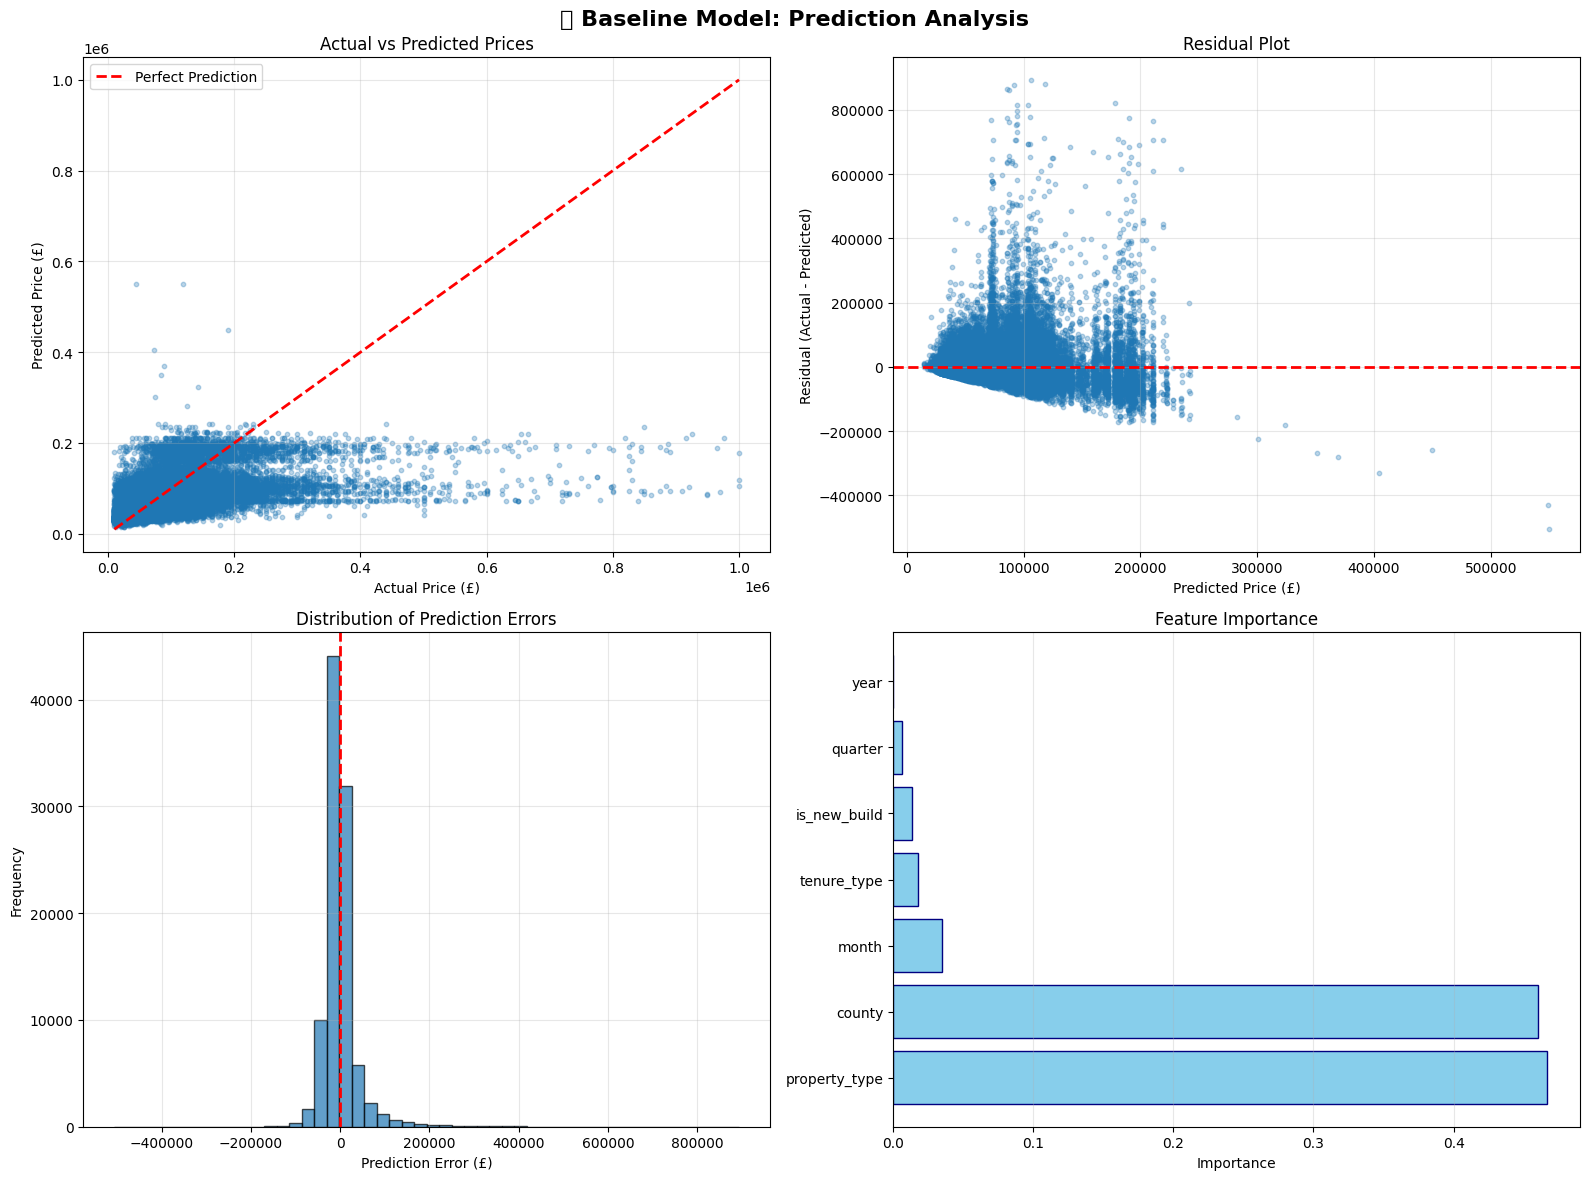


🔍 FEATURE IMPORTANCE:
  property_type       : 0.4668
  county              : 0.4603
  month               : 0.0352
  tenure_type         : 0.0178
  is_new_build        : 0.0134
  quarter             : 0.0064
  year                : 0.0000


In [ ]:
# ==========================================
# 8. Visualize Predictions
# ==========================================
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('🌲 Baseline Model: Prediction Analysis', fontsize=16, fontweight='bold')

# 1. Actual vs Predicted scatter
ax1.scatter(y_test, y_pred, alpha=0.3, s=10)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Price (£)')
ax1.set_ylabel('Predicted Price (£)')
ax1.set_title('Actual vs Predicted Prices')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Residuals (errors)
residuals = y_test - y_pred
ax2.scatter(y_pred, residuals, alpha=0.3, s=10)
ax2.axhline(y=0, color='r', linestyle='--', lw=2)
ax2.set_xlabel('Predicted Price (£)')
ax2.set_ylabel('Residual (Actual - Predicted)')
ax2.set_title('Residual Plot')
ax2.grid(True, alpha=0.3)

# 3. Error distribution
ax3.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
ax3.axvline(x=0, color='r', linestyle='--', lw=2)
ax3.set_xlabel('Prediction Error (£)')
ax3.set_ylabel('Frequency')
ax3.set_title('Distribution of Prediction Errors')
ax3.grid(True, alpha=0.3)

# 4. Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

bars = ax4.barh(feature_importance['feature'], feature_importance['importance'], 
                color='skyblue', edgecolor='navy')
ax4.set_xlabel('Importance')
ax4.set_title('Feature Importance')
ax4.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# Print feature importance
print("\n🔍 FEATURE IMPORTANCE:")
print("="*50)
for idx, row in feature_importance.iterrows():
    print(f"  {row['feature']:20s}: {row['importance']:.4f}")

## 💾 Save Model Results

Save the model and metrics for later comparison.

In [ ]:
## 💾 Save Model Results

Save the model and metrics for later comparison.

SyntaxError: invalid syntax (723318216.py, line 3)

In [ ]:
# ==========================================
# 9. Save Model and Results
# ==========================================
import pickle

print("💾 Saving model and results...")

# Save model
model_path = Path("models/baseline_random_forest.pkl")
model_path.parent.mkdir(parents=True, exist_ok=True)

with open(model_path, 'wb') as f:
    pickle.dump(model, f)

# Save metrics
metrics = {
    'model_name': 'Baseline Random Forest',
    'mae': mae,
    'rmse': rmse,
    'r2': r2,
    'mape': mape,
    'n_train': len(X_train),
    'n_test': len(X_test),
    'features': feature_columns
}

metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv("models/baseline_metrics.csv", index=False)

print(f"✅ Model saved to {model_path}")
print(f"✅ Metrics saved to models/baseline_metrics.csv")
print(f"   Model file size: {model_path.stat().st_size / (1024**2):.1f} MB")